In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv


The presence of generic words like "that" , "price", "market", "investor" can suppress the meaningful words. 
-> so the computer can think that some texts are similair even if they are not about the same topic.
 That's why we must see the :
 **Document frequency**= Number of times term t is present in all docs.
 So if a term is present in almost all the documents, we must lower its influence.

 on the other hand, if some word is appearing only in few docs, so that term is important and we must to give it a high score.
 the score is IDF(t) = log(Total docs/Number of docs term t is present in)
 this is what we call **IDF**!!! : Inverse Document Frequency.
 
Let's introduce now Term Frequency !!! **TF**:
TF(t,d)=(total number of time term t is present in doc A/ total number of tokens in doc A).

Tf-IDf = TF(t,d)*IDF(t)

this text representation unfortunateliy doesn't capture relationship between words also!!



**Problem Statement: Given a description about a product sold on e-commerce website, classify it in one of the 4 categories**

**Dataset**:
Text: Description of an item sold on e-commerce website.
Label: Category of that item. Total 4 categories: "Electronics", "Household", "Books" and "Clothing & Accessories", which almost cover 80% of any E-commerce website.

In [7]:
import pandas as pd

#read the data into a pandas dataframe
df = pd.read_csv("/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv", header=0)
print(df.shape)
df.head()

(50424, 2)


,Household,"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room."
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [8]:
df.columns = ["label", "text"]
df.head()

,label,text
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [9]:
#check the distribution of labels 
df['label'].value_counts()

label
Household                 19312
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

In [10]:
df['text'][0]

"SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch (A perfect gift for your special ones)."

Check if there is missing texts:

In [11]:
print(df["text"].isnull().sum())

1


In [12]:
df[df["text"].isnull()]

,label,text
39329,Clothing & Accessories,NaN


Check if there is missing labels

In [13]:
print(df["label"].isnull().sum())

0


In [14]:
df = df.dropna(subset=["text"])

In [15]:
print(df["text"].isnull().sum())

0


In [16]:
#check the distribution of labels 
df['label'].value_counts()

label
Household                 19312
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64

The data is imbalanced. For simplicity, I will use the **undersampling** technique :

In [19]:
min_samples = 8670 # we have these many Clothing & Accessories categories and this is our minority class


df_Household = df[df.label=="Household"].sample(min_samples, random_state=2025)
df_Books = df[df.label=="Books"].sample(min_samples, random_state=2025)
df_Electronics = df[df.label=="Electronics"].sample(min_samples, random_state=2025)
df_Clothing_Accessoires = df[df.label=="Clothing & Accessories"].sample(min_samples, random_state=2025)

In [20]:
df_balanced = pd.concat([df_Household,df_Books,df_Electronics,df_Clothing_Accessoires],axis=0)
df_balanced.label.value_counts()

label
Household                 8670
Books                     8670
Electronics               8670
Clothing & Accessories    8670
Name: count, dtype: int64

In [21]:
#Add the new column which gives a unique number to each of these labels 

df_balanced['label_num'] = df_balanced['label'].map({
    'Household' : 0, 
    'Books': 1, 
    'Electronics': 2, 
    'Clothing & Accessories': 3
})

#checking the results 
df_balanced.head()

,label,text,label_num
1107,Household,myWoodKart Wooden Round Shape Stool/Table Made...,0
2297,Household,Aart Store Washable Cover Sofa Cum Bed One Sea...,0
9132,Household,Wingreens Farms Multigrain Flatbread 100g,0
4820,Household,Shopizone Mini 36 Pockets Album for Instax Min...,0
17246,Household,SHAFIRE 19mm Woodworking Drilling Drill Bit To...,0


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2025,
    stratify=df_balanced.label_num
)

In [23]:

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (27744,)
Shape of X_test:  (6936,)


In [24]:

X_train.head()

24072    Yoga Spandakarika: The Sacred Texts at the Ori...
31421    Minor Mappillai Boys' Silk Clothing Set Minor ...
27506    Living Language: Italian 2019 Day-to-Day Calen...
3046     Usha Maxx Air 400mm Pedestal Fan (White) Motor...
25394    Dick Francis's Refusal Review Praise for Dick ...
Name: text, dtype: object

In [25]:
y_train.value_counts()

label_num
1    6936
3    6936
0    6936
2    6936
Name: count, dtype: int64

In [26]:

y_test.value_counts()

label_num
2    1734
3    1734
1    1734
0    1734
Name: count, dtype: int64

**Attempt 1 :**


using sklearn pipeline module create a classification pipeline to classify the Ecommerce Data.

Note:

use TF-IDF for pre-processing the text.

use KNN as the classifier

print the classification report.

In [27]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),    
     ('KNN', KNeighborsClassifier())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1734
           1       0.97      0.95      0.96      1734
           2       0.95      0.95      0.95      1734
           3       0.97      0.98      0.98      1734

    accuracy                           0.96      6936
   macro avg       0.96      0.96      0.96      6936
weighted avg       0.96      0.96      0.96      6936



**Attempt 2 :**

using sklearn pipeline module create a classification pipeline to classify the Ecommerce Data.
Note:

use TF-IDF for pre-processing the text.

use MultinomialNB as the classifier.

print the classification report.

In [28]:
from sklearn.naive_bayes import MultinomialNB


#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),    
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1734
           1       0.98      0.93      0.95      1734
           2       0.95      0.94      0.95      1734
           3       0.96      0.98      0.97      1734

    accuracy                           0.95      6936
   macro avg       0.95      0.95      0.95      6936
weighted avg       0.95      0.95      0.95      6936



**Attempt 3 :**

using sklearn pipeline module create a classification pipeline to classify the Ecommerce Data.
Note:

use TF-IDF for pre-processing the text.

use Random Forest as the classifier.

print the classification report.

In [29]:

from sklearn.ensemble import RandomForestClassifier

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),        #using the ngram_range parameter 
     ('Random Forest', RandomForestClassifier())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1734
           1       0.97      0.96      0.96      1734
           2       0.97      0.94      0.95      1734
           3       0.97      0.98      0.98      1734

    accuracy                           0.96      6936
   macro avg       0.96      0.96      0.96      6936
weighted avg       0.96      0.96      0.96      6936



**Use text pre-processing to remove stop words, punctuations and apply lemmatization**

In [30]:
### utlity function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [31]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess) 

In [33]:
df_balanced.head()

,label,text,label_num,preprocessed_txt
1107,Household,myWoodKart Wooden Round Shape Stool/Table Made...,0,myWoodKart Wooden Round Shape Stool Table Natu...
2297,Household,Aart Store Washable Cover Sofa Cum Bed One Sea...,0,Aart Store Washable Cover Sofa Cum Bed Seater ...
9132,Household,Wingreens Farms Multigrain Flatbread 100g,0,Wingreens Farms Multigrain Flatbread 100 g
4820,Household,Shopizone Mini 36 Pockets Album for Instax Min...,0,Shopizone Mini 36 Pockets Album Instax Mini 8/...
17246,Household,SHAFIRE 19mm Woodworking Drilling Drill Bit To...,0,SHAFIRE 19 mm Woodworking Drilling Drill Bit T...


**Build a model with pre processed text**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.label_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2025,
    stratify=df_balanced.label_num
)

**Let's check the scores with our best model till now**

In [36]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),        #using the ngram_range parameter 
     ('Random Forest', RandomForestClassifier())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1734
           1       0.97      0.96      0.97      1734
           2       0.97      0.95      0.96      1734
           3       0.97      0.99      0.98      1734

    accuracy                           0.96      6936
   macro avg       0.96      0.96      0.96      6936
weighted avg       0.96      0.96      0.96      6936



Comparing above classification report with respect to RandomForest Model with the one from unprocessed text, we observe some improvement in the model that uses preprocessed cleaned up text. The F1 score improved in the case of preprocessed data. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model.

**Plot confusion matrix**

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1658,   23,   26,   27],
       [  36, 1667,   13,   18],
       [  65,   20, 1642,    7],
       [  12,    7,    7, 1708]])

Text(95.72222222222221, 0.5, 'Truth')

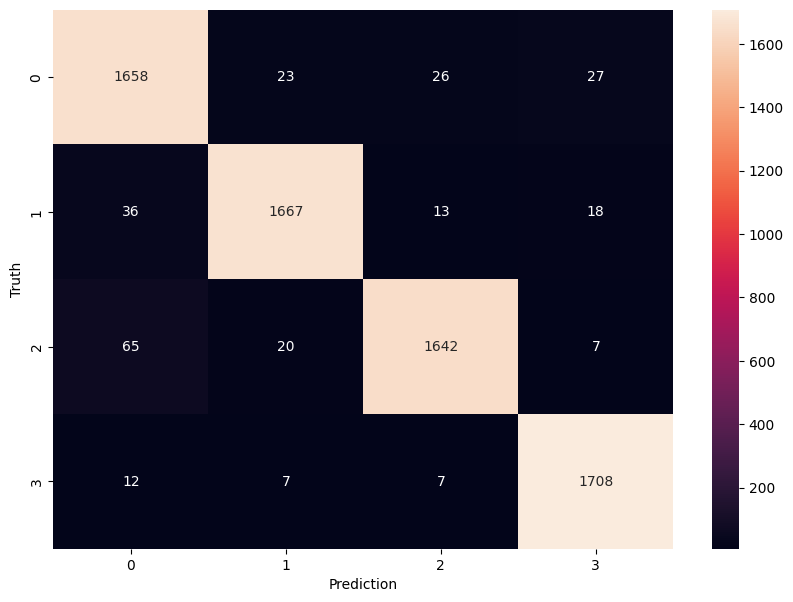

In [38]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')